## Regional wettest and driest years polygon appender

This code takes a shapefile of areas with common driest years. 


-It loops through the polygons in the shapefile and calculates 5th and 95th percentile in rainfall from the BoM rainfall data, and returns the years which are over/under those margins.

-for each shapefile it will add the wet and dry years to the polygon attribute table

#this has been re-written to use the rainfall for the box containing the polygon, where the polygon is small enough that there is no result otherwise. Is this a masking issue? 
Bex Dunn July 2017
Changelog
#edited to only have to enter the shapefile once 07-08-17

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import geopandas as gpd
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import scipy.stats
import pandas
#import csv
import os

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

import pickle
import logging
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

#python logging 
logging.getLogger('datacube.storage.storage').setLevel(logging.ERROR)
dc = datacube.Datacube(app='dc-BOMrainfall')

In [2]:
#mask to use with our polygons to calculate wet and dry years 
#(comes from http://agdc-v2.readthedocs.io/en/stable/user/guide.html#code-recipes)
def geometry_mask(geoms, geobox, all_touched=True, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [3]:
#Use geopandas to read in the attribute table as a geodataframe

In [19]:
shapefile = '/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10.shp'

In [20]:
big_poly = gpd.read_file(shapefile)
print(shapefile)

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10.shp


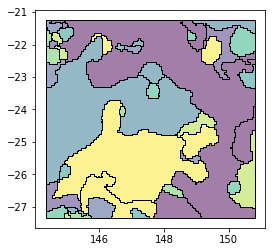

In [21]:
big_poly.plot()
plt.show()

In [23]:
#Make sure we have an ID column, and that it is equal to the index plus one
big_poly['ID'] = big_poly.index +1

In [26]:
big_poly.head()

,DN,geometry,ID,WY1,WY2,DY1,DY2
0,1991,"POLYGON ((144.5 -21.25, 144.9 -21.25, 144.9 -2...",1,None,None,None,None
1,2002,"POLYGON ((144.9 -21.25, 144.95 -21.25, 144.95 ...",2,None,None,None,None
2,2003,"POLYGON ((144.35 -21.25, 144.5 -21.25, 144.5 -...",3,None,None,None,None
3,2003,"POLYGON ((148.85 -21.25, 150.8 -21.25, 150.8 -...",4,None,None,None,None
4,1993,"POLYGON ((145 -21.4, 145.05 -21.4, 145.05 -21....",5,None,None,None,None


In [27]:
#create an empty column
big_poly['WY1'] = None
big_poly['WY2'] = None
big_poly['DY1'] = None
big_poly['DY2'] = None

In [28]:
#copy across rainpath and shapefile from previous notebook

In [29]:
start_of_epoch = '1987-10-01'
#need a variable here that defines a rolling 'latest observation'  
end_of_epoch =  '2012-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2012-10-01


In [30]:
# #pick a shape file
shape_file = shapefile
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
#i = int(input("choose the index of the polygon you want to investigate:"))
for i in range(len(shapes)): 
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
    print(shape_name)

    query = {
           'time': (start_of_epoch,end_of_epoch ),
    #          'x': (geom.bounds[0], geom.bounds[2]),
    #          'y': (geom.bounds[1], geom.bounds[3]),
           'geopolygon': geom
    #         'crs': geom_crs,
        }

    Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
    #make a dictionary of the data we want to save


    #Ran into an issue where the mask is removing all the data for small shapes???
    ######## follow this up #########

    #Mask the data with the polygon. Invert = True means you want the contents of the mask
    #I've added 'all touched = True, otherwise we get nothing in the output.
    mask = geometry_mask([geom], Studysite_rain.geobox, all_touched=True,invert=True)
    Studysite_rain_masked = Studysite_rain.where(mask)

    #rain nones is an array of nones. we use it to check and see if there is actually any data

    rain_nones = xr.full_like(Studysite_rain,None)

    if Studysite_rain_masked ==rain_nones:
        print('Not using the mask because it leaves no data behind!')
        Studysite_rain_masked = Studysite_rain

    Studysite_rain_masked

    #resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
    #Note that the resampling we did means that each year is labelled according to its first day  
    year_avg = Studysite_rain_masked.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)

    # Create a spatial average
    year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

    # Find the 95th percentile in rainfall
    threshold95 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 95)

    # Find the 5th percentile in rainfall (least)
    threshold5 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 5)
    #print('5th  q: ',threshold5.rainfall.values,'\n'+'95th q: ',threshold95.rainfall.values )

    #work out which of the years have rainfall greater than 95th and less than 5th percentile
    wet_yrs = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).dropna(dim = 'time')
    dry_yrs = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).dropna(dim = 'time')

    #turn into numpy datetimes for later timeslicing
    wet_dt=np.array(wet_yrs.time.values,dtype = 'datetime64[Y]')
    dry_dt=np.array(dry_yrs.time.values,dtype = 'datetime64[Y]')

    #print out our wet and dry years
    print('wet years begin: ', wet_dt)
    print('dry years begin: ', dry_dt)

    #type(wet_dt[0])
    print(i)
    print('driest year is :',big_poly.DN[i])

    #now add the wet and dry years back into the geodataframe
    big_poly.set_value(i,'WY1',str(wet_dt[0]))
    big_poly.set_value(i,'WY2',str(wet_dt[1]))
    big_poly.set_value(i,'DY1',str(dry_dt[0]))
    big_poly.set_value(i,'DY2',str(dry_dt[1]))

Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_0


Not using the mask because it leaves no data behind!
wet years begin:  ['1999' '2009']
dry years begin:  ['1987' '1991']
0
driest year is : 1991
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_1


Not using the mask because it leaves no data behind!
wet years begin:  ['1999' '2009']
dry years begin:  ['2002' '2003']
1
driest year is : 2002
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_2


Not using the mask because it leaves no data behind!
wet years begin:  ['1989' '1999']
dry years begin:  ['1987' '2003']
2
driest year is : 2003
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_3


Not using the mask because it leaves no data behind!
wet years begin:  ['1990' '2010']
dry years begin:  ['1994' '2003']
3
driest year is : 2003
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_4


Not using the mask because it leaves no data behind!
wet years begin:  ['1999' '2009']
dry years begin:  ['1993' '2002']
4
driest year is : 1993
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_5


Not using the mask because it leaves no data behind!
wet years begin:  ['1990' '2010']
dry years begin:  ['1994' '2002']
5
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_6


Not using the mask because it leaves no data behind!
wet years begin:  ['1989' '1999']
dry years begin:  ['1993' '1994']
6
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_7


Not using the mask because it leaves no data behind!
wet years begin:  ['1999' '2011']
dry years begin:  ['1993' '1995']
7
driest year is : 1995
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_8


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1991' '2002']
8
driest year is : 1991
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_9


Not using the mask because it leaves no data behind!
wet years begin:  ['1990' '2010']
dry years begin:  ['1994' '2002']
9
driest year is : 2002
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_10


Not using the mask because it leaves no data behind!
wet years begin:  ['1989' '1999']
dry years begin:  ['1993' '1994']
10
driest year is : 1993
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_11


Not using the mask because it leaves no data behind!
wet years begin:  ['2007' '2010']
dry years begin:  ['1991' '1992']
11
driest year is : 1991
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_12


Not using the mask because it leaves no data behind!
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '1993']
12
driest year is : 1993
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_13


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1992' '1994']
13
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_14


Not using the mask because it leaves no data behind!
wet years begin:  ['1987' '1988']
dry years begin:  ['1994' '1996']
14
driest year is : 1996
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_15


Not using the mask because it leaves no data behind!
wet years begin:  ['1999' '2009']
dry years begin:  ['1992' '2001']
15
driest year is : 1992
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_16


Not using the mask because it leaves no data behind!
wet years begin:  ['1999' '2009']
dry years begin:  ['1992' '2001']
16
driest year is : 2001
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_17


Not using the mask because it leaves no data behind!
wet years begin:  ['1990' '2010']
dry years begin:  ['1994' '2001']
17
driest year is : 2001
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_18


Not using the mask because it leaves no data behind!
wet years begin:  ['1988' '2010']
dry years begin:  ['1996' '2003']
18
driest year is : 2003
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_19


Not using the mask because it leaves no data behind!
wet years begin:  ['1990' '2010']
dry years begin:  ['1994' '2003']
19
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_20


Not using the mask because it leaves no data behind!
wet years begin:  ['1989' '2009']
dry years begin:  ['1987' '2002']
20
driest year is : 1987
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_21


Not using the mask because it leaves no data behind!
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2001']
21
driest year is : 2001
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_22


Not using the mask because it leaves no data behind!
wet years begin:  ['1988' '2010']
dry years begin:  ['1992' '2003']
22
driest year is : 2003
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_23


Not using the mask because it leaves no data behind!
wet years begin:  ['2007' '2010']
dry years begin:  ['1994' '2002']
23
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_24


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1990' '1993']
24
driest year is : 1993
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_25


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1994' '2002']
25
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_26


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1992' '1993']
26
driest year is : 1993
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_27


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1992' '1994']
27
driest year is : 1994
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_28


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1990' '1992']
28
driest year is : 1992
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_29


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1993' '2005']
29
driest year is : 2005
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_30


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1992' '2002']
30
driest year is : 2002
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_31


Not using the mask because it leaves no data behind!
wet years begin:  ['2007' '2009']
dry years begin:  ['1990' '1991']
31
driest year is : 1991
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_32


Not using the mask because it leaves no data behind!
wet years begin:  ['1997' '2010']
dry years begin:  ['1992' '2000']
32
driest year is : 2000
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_33


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['2005' '2006']
33
driest year is : 2005
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_34


Not using the mask because it leaves no data behind!
wet years begin:  ['1997' '2010']
dry years begin:  ['1990' '1992']
34
driest year is : 1990
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_35


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1990' '2002']
35
driest year is : 1990
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_36


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2010']
dry years begin:  ['1992' '2002']
36
driest year is : 1992
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_37


Not using the mask because it leaves no data behind!
wet years begin:  ['1989' '2009']
dry years begin:  ['1990' '2005']
37
driest year is : 2005
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_38


Not using the mask because it leaves no data behind!
wet years begin:  ['2007' '2009']
dry years begin:  ['1991' '2002']
38
driest year is : 2002
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_39


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1990' '2004']
39
driest year is : 1990
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_40


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1991' '2002']
40
driest year is : 2002
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_41


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1990' '2004']
41
driest year is : 2004
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_42


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1990' '2004']
42
driest year is : 2004
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_43


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1990' '2004']
43
driest year is : 1990
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_44


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1990' '1991']
44
driest year is : 1991
Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_45


Not using the mask because it leaves no data behind!
wet years begin:  ['2009' '2011']
dry years begin:  ['1992' '2006']
45
driest year is : 2006


In [31]:
#drop the .shp so we can add wydy, and then stick it back together
WYDY_out_shape_file=shape_file.split('.')[0]+'_WYDY'+'.shp'
print(WYDY_out_shape_file)

/g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_WYDY.shp


In [32]:
if input('Ready to write this out to: '+WYDY_out_shape_file+'? (y please)') == 'y':
    big_poly.to_file(WYDY_out_shape_file, driver='ESRI Shapefile')

Ready to write this out to: /g/data/r78/rjd547/groundwater_activities/East_Kimberley/GW_shapefiles_ord_ek_stuart/Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_WYDY.shp? (y please)y


In [38]:
#and just to check that it is in there
dir_path = os.path.dirname(os.path.realpath(WYDY_out_shape_file))
os.listdir(dir_path)

['Rain_Surat_Galilee_1987-10-01_2012-10-01.nc',
 'out.prj',
 'EK_3577_test.prj',
 'Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10.shx',
 'Gridded_EK_50k_140717.prj',
 'Rain_East_Kimberley_1987-10-01_2012-10-01_WYDY_3577test.shp',
 'GW_shapefiles_EK_Stuard_ordBon.shp.xml',
 'Rain_East_Kimberley_1987-10-01_2012-10-01.shp',
 'Gridded_EK_50k_140717.cpg',
 'Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10_WYDY.shp',
 'EK_3577_test.qpj',
 'EK_50k_grid_for_dask_140717.shp',
 'Gridded_EK_50k_140717.shx',
 'Rain_Northern_Stuart_Corridor_1987-10-01_2012-10-01_sv10.prj',
 'GW_shapefiles_EK_Stuard_ordBon.sbx',
 'EK_50k_grid_for_dask_140717.prj',
 'Gridded_EK_50k_140717.dbf',
 'GW_shapefiles_EK_Stuard_ordBon.sbn',
 'Rain_East_Kimberley_1987-10-01_2012-10-01.tif',
 'Rain_East_Kimberley_1987-10-01_2012-10-01_WYDY.prj',
 'Rain_Surat_Galilee_1987-10-01_2012-10-01_sv10.tif',
 'EK_50k_grid_for_dask_140717.shx',
 'Rain_East_Kimberley_1987-10-01_2012-10-01_WYDY_3577test.qpj',
 'Rain_Northern_Stuart_Corridor_19

In [39]:
big_poly

,DN,geometry,ID,WY1,WY2,DY1,DY2
0,1991,"POLYGON ((144.5 -21.25, 144.9 -21.25, 144.9 -2...",1,1999,2009,1987,1991
1,2002,"POLYGON ((144.9 -21.25, 144.95 -21.25, 144.95 ...",2,1999,2009,2002,2003
2,2003,"POLYGON ((144.35 -21.25, 144.5 -21.25, 144.5 -...",3,1989,1999,1987,2003
3,2003,"POLYGON ((148.85 -21.25, 150.8 -21.25, 150.8 -...",4,1990,2010,1994,2003
4,1993,"POLYGON ((145 -21.4, 145.05 -21.4, 145.05 -21....",5,1999,2009,1993,2002
5,1994,"POLYGON ((148.7 -21.55, 148.8 -21.55, 148.8 -2...",6,1990,2010,1994,2002
6,1994,"POLYGON ((144.35 -21.45, 144.4 -21.45, 144.4 -...",7,1989,1999,1993,1994
7,1995,"POLYGON ((144.55 -21.6, 144.7 -21.6, 144.7 -21...",8,1999,2011,1993,1995
8,1991,"POLYGON ((145.85 -21.65, 146.05 -21.65, 146.05...",9,2009,2011,1991,2002
9,2002,"POLYGON ((148.55 -21.25, 148.85 -21.25, 148.85...",10,1990,2010,1994,2002


In [35]:
#!ogrinfo /g/data/r78/rjd547/groundwater_activities/Stuart_Cor/shapefiles/StHWy_wyonly_WYDY.shp


INFO: Open of `/g/data/r78/rjd547/groundwater_activities/Stuart_Cor/shapefiles/StHWy_wyonly_WYDY.shp'
      using driver `ESRI Shapefile' successful.
1: StHWy_wyonly_WYDY (Polygon)


In [40]:
new_poly = gpd.read_file(WYDY_out_shape_file)

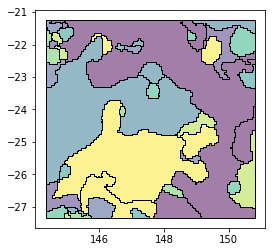

In [41]:
new_poly.plot()